In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import multivariate_normal, norm

import pymc3 as pm

In [2]:
dat = pd.DataFrame([['afarensis', 438, 37],
                    ['africanus', 452, 35.5],
                    ['habilis', 612, 34.5],
                    ['boisei', 521, 41.5],
                    ['rudolfensis', 752, 55.5],
                    ['ergaster', 871, 61],
                    ['sapiens', 1350, 53.5],
                   ], columns=['Species', 'Brain_cc', 'Mass_kg'])

n_dat = dat.shape[0]

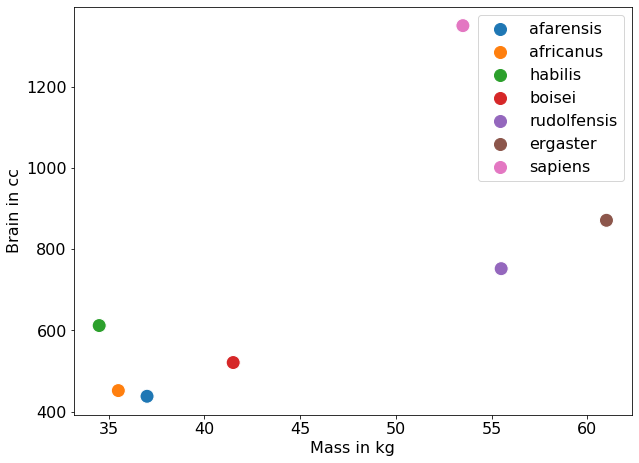

In [3]:
plt.figure(figsize=(10,7.5))
sns.scatterplot(data=dat, x='Mass_kg', y='Brain_cc', hue='Species', s=200)
plt.xlabel('Mass in kg', fontsize=16)
plt.ylabel('Brain in cc', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, markerscale=2)

In [4]:
mass_std  = (dat['Mass_kg']-dat['Mass_kg'].mean())/dat['Mass_kg'].std()
brain_std = dat['Brain_cc']/dat['Brain_cc'].max()

mass_seq  = np.linspace(mass_std.min(), mass_std.max())
brain_max = dat['Brain_cc'].max()

# Model 1, 1-degree polinomial

In [5]:
with pm.Model() as model_1:
    alpha = pm.Normal('alpha', mu=0.5, sigma=1)
    beta  = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.Lognormal('sigma', mu=0, sigma=1)
    mu    = alpha + beta*mass_std
    brain = pm.Normal('brain', mu=mu, sigma=sigma, observed=brain_std)

    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta, sigma])

    

In [6]:
param_mu_post = [par_post['alpha'], par_post['beta'], par_post['sigma']]
sample_post   = multivariate_normal.rvs(size=10**4, mean=param_mu_post, cov=np.linalg.inv(hessian))
sample_post   = pd.DataFrame(sample_post, columns=['alpha', 'beta', 'sigma'])

In [7]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(
        (sample_post['alpha'] + sample_post['beta']*mass_seq[0])*brain_max,
        [0.025, 0.975]
    ).reshape(1,2),
    columns=['LCI', 'UCI']
)

In [8]:
for i in range(1, len(mass_seq)):
    ConfidenceIntervals = pd.concat(
        [
            ConfidenceIntervals,
            pd.DataFrame(
                np.quantile(
                    (sample_post['alpha'] + sample_post['beta']*mass_seq[i])*brain_max,
                    [0.025, 0.975]
                ).reshape(1,2),
                columns=['LCI', 'UCI']
            )
        ]
    )

In [9]:
ConfidenceIntervals['Mass_kg'] = mass_seq*dat['Mass_kg'].std()+dat['Mass_kg'].mean()

In [10]:
lppd = 0
penalty = 0
WAIC_sample = []

for i in range(n_dat):
    p_y_post = norm.pdf(
        brain_std[i],
        loc = sample_post['alpha'] + sample_post['beta']*mass_std[i],
        scale = sample_post['sigma']
    )

    p_y_post         = p_y_post[~np.isnan(p_y_post)]
    log_p_y_post     = np.log(np.mean(p_y_post))
    p_y_post         = p_y_post[p_y_post>0]
    var_log_p_y_post = np.var(np.log(p_y_post)) 
    lppd    += log_p_y_post
    penalty += var_log_p_y_post
    WAIC_sample.append(-2*(log_p_y_post-var_log_p_y_post))

WAIC = -2*(lppd - penalty)
WAIC_std_error = np.sqrt(n_dat*np.var(WAIC_sample))

In [11]:
WAIC_models = []
WAIC_std_error_models = []
WAIC_models.append(WAIC)
WAIC_std_error_models.append(WAIC_std_error)

In [12]:
resid = brain_std - (par_post['alpha'] + par_post['beta']*mass_std)
R_2   = np.round(1-np.var(resid)/np.var(brain_std), 2)

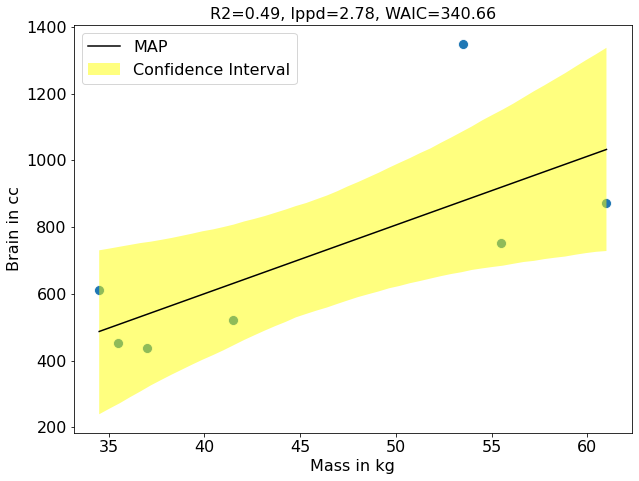

In [13]:
plt.figure(figsize=(10,7.5))

sns.scatterplot(data=dat, x='Mass_kg', y='Brain_cc', s=100)

plt.plot(
    [dat['Mass_kg'].min(), dat['Mass_kg'].max()],
    [(par_post['alpha'] + par_post['beta']*mass_seq.min())*brain_max,
    (par_post['alpha'] + par_post['beta']*mass_seq.max())*brain_max
    ],
    color='k', label='MAP'
)

plt.fill_between(ConfidenceIntervals['Mass_kg'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'], facecolor='yellow', alpha=0.5, label='Confidence Interval')

plt.title('R2='+str(R_2)+', lppd='+str(round(lppd, 2))+', WAIC='+str(round(WAIC, 2)), fontsize=16)
plt.xlabel('Mass in kg', fontsize=16)
plt.ylabel('Brain in cc', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

# Model 2, 2-degree polinomial

In [14]:
with pm.Model() as model_2:
    alpha = pm.Normal('alpha', mu=0.5, sigma=1)
    beta  = pm.Normal('beta', mu=0, sigma=1, shape=2)
    sigma = pm.Lognormal('sigma', mu=0, sigma=1)
    mu    = alpha + beta[0]*mass_std + beta[1]*mass_std**2
    brain = pm.Normal('brain', mu=mu, sigma=sigma, observed=brain_std)

    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta, sigma])

    

In [15]:
param_mu_post = [par_post['alpha'], par_post['beta'][0], par_post['beta'][1], par_post['sigma']]
sample_post   = multivariate_normal.rvs(size=10**4, mean=param_mu_post, cov=np.linalg.inv(hessian))
sample_post   = pd.DataFrame(sample_post, columns=['alpha', 'beta1', 'beta2', 'sigma'])

In [16]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(
        (sample_post['alpha'] + sample_post['beta1']*mass_seq[0] + sample_post['beta2']*mass_seq[0]**2)*brain_max,
        [0.025, 0.975]
    ).reshape(1,2),
    columns=['LCI', 'UCI']
)

In [17]:
for i in range(1, len(mass_seq)):
    ConfidenceIntervals = pd.concat(
        [
            ConfidenceIntervals,
            pd.DataFrame(
                np.quantile(
                    (sample_post['alpha'] + sample_post['beta1']*mass_seq[i] + sample_post['beta2']*mass_seq[i]**2)*brain_max,
                    [0.025, 0.975]
                ).reshape(1,2),
                columns=['LCI', 'UCI']
            )
        ]
    )

In [18]:
ConfidenceIntervals['MAP'] = (par_post['alpha'] + par_post['beta'][0]*mass_seq + par_post['beta'][1]*mass_seq**2)*brain_max
ConfidenceIntervals['Mass_kg'] = mass_seq*dat['Mass_kg'].std()+dat['Mass_kg'].mean()

In [19]:
lppd = 0
penalty = 0
WAIC_sample = []

for i in range(n_dat):
    p_y_post = norm.pdf(
        brain_std[i],
        loc = sample_post['alpha'] + sample_post['beta1']*mass_std[i] + sample_post['beta2']*mass_std[i]**2,
        scale = sample_post['sigma']
    )

    p_y_post         = p_y_post[~np.isnan(p_y_post)]
    log_p_y_post     = np.log(np.mean(p_y_post))
    p_y_post         = p_y_post[p_y_post>0]
    var_log_p_y_post = np.var(np.log(p_y_post)) 
    lppd    += log_p_y_post
    penalty += var_log_p_y_post
    WAIC_sample.append(-2*(log_p_y_post-var_log_p_y_post))

WAIC = -2*(lppd - penalty)
WAIC_std_error = np.sqrt(n_dat*np.var(WAIC_sample))
WAIC_models.append(WAIC)
WAIC_std_error_models.append(WAIC_std_error)

In [20]:
resid = brain_std - (par_post['alpha'] + par_post['beta'][0]*mass_std + par_post['beta'][1]*mass_std**2)
R_2   = np.round(1-np.var(resid)/np.var(brain_std), 2)

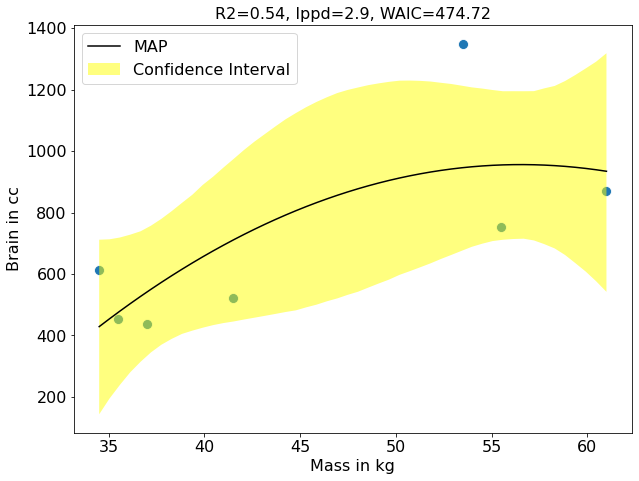

In [21]:
plt.figure(figsize=(10,7.5))

sns.scatterplot(data=dat, x='Mass_kg', y='Brain_cc', s=100)

plt.plot(
    ConfidenceIntervals['Mass_kg'],
    ConfidenceIntervals['MAP'],
    color='k', label='MAP'
)

plt.fill_between(ConfidenceIntervals['Mass_kg'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'], facecolor='yellow', alpha=0.5, label='Confidence Interval')

plt.title('R2='+str(R_2)+', lppd='+str(round(lppd, 2))+', WAIC='+str(round(WAIC, 2)), fontsize=16)
plt.xlabel('Mass in kg', fontsize=16)
plt.ylabel('Brain in cc', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

# Model 3, 3-degree polinomial

In [22]:
with pm.Model() as model_3:
    alpha = pm.Normal('alpha', mu=0.5, sigma=1)
    beta  = pm.Normal('beta', mu=0, sigma=1, shape=3)
    sigma = pm.Lognormal('sigma', mu=0, sigma=1)
    mu    = alpha + beta[0]*mass_std + beta[1]*mass_std**2 + beta[2]*mass_std**3
    brain = pm.Normal('brain', mu=mu, sigma=sigma, observed=brain_std)

    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta, sigma])

    

In [23]:
param_mu_post = [par_post['alpha'], par_post['beta'][0], par_post['beta'][1], par_post['beta'][2], par_post['sigma']]
sample_post   = multivariate_normal.rvs(size=10**4, mean=param_mu_post, cov=np.linalg.inv(hessian))
sample_post   = pd.DataFrame(sample_post, columns=['alpha', 'beta1', 'beta2', 'beta3', 'sigma'])

In [24]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(
        (sample_post['alpha']
        + sample_post['beta1']*mass_seq[0]
        + sample_post['beta2']*mass_seq[0]**2
        + sample_post['beta3']*mass_seq[0]**3)*brain_max,
        [0.025, 0.975]
    ).reshape(1,2),
    columns=['LCI', 'UCI']
)

In [25]:
for i in range(1, len(mass_seq)):
    ConfidenceIntervals = pd.concat(
        [
            ConfidenceIntervals,
            pd.DataFrame(
                np.quantile(
                    (sample_post['alpha']
                    + sample_post['beta1']*mass_seq[i]
                    + sample_post['beta2']*mass_seq[i]**2
                    + sample_post['beta3']*mass_seq[i]**3)*brain_max,
                    [0.025, 0.975]
                ).reshape(1,2),
                columns=['LCI', 'UCI']
            )
        ]
    )

In [26]:
ConfidenceIntervals['MAP'] = (
    par_post['alpha']
    + par_post['beta'][0]*mass_seq
    + par_post['beta'][1]*mass_seq**2
    + par_post['beta'][2]*mass_seq**3)*brain_max
    
ConfidenceIntervals['Mass_kg'] = mass_seq*dat['Mass_kg'].std()+dat['Mass_kg'].mean()

In [27]:
lppd = 0
penalty = 0
WAIC_sample = []

for i in range(n_dat):
    p_y_post = norm.pdf(
        brain_std[i],
        loc = sample_post['alpha']
            + sample_post['beta1']*mass_std[i]
            + sample_post['beta2']*mass_std[i]**2
            + sample_post['beta3']*mass_std[i]**3,
        scale = sample_post['sigma']
    )

    p_y_post         = p_y_post[~np.isnan(p_y_post)]
    log_p_y_post     = np.log(np.mean(p_y_post))
    p_y_post         = p_y_post[p_y_post>0]
    var_log_p_y_post = np.var(np.log(p_y_post)) 
    lppd    += log_p_y_post
    penalty += var_log_p_y_post
    WAIC_sample.append(-2*(log_p_y_post-var_log_p_y_post))

WAIC = -2*(lppd - penalty)
WAIC_std_error = np.sqrt(n_dat*np.var(WAIC_sample))
WAIC_models.append(WAIC)
WAIC_std_error_models.append(WAIC_std_error)

In [28]:
resid = brain_std - (
    par_post['alpha']
    + par_post['beta'][0]*mass_std
    + par_post['beta'][1]*mass_std**2
    + par_post['beta'][2]*mass_std**3)
R_2   = np.round(1-np.var(resid)/np.var(brain_std), 2)

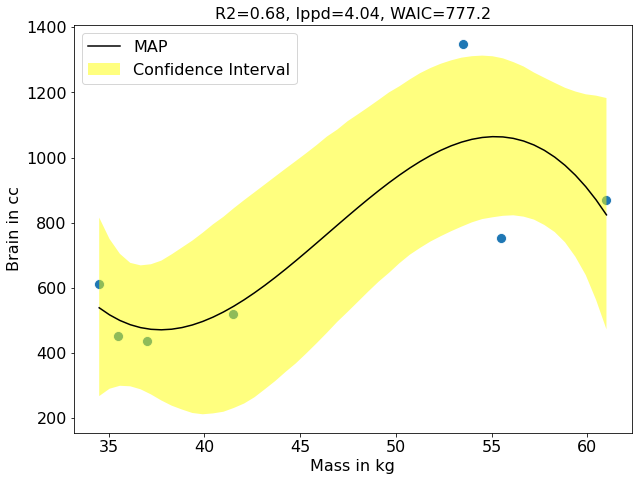

In [29]:
plt.figure(figsize=(10,7.5))

sns.scatterplot(data=dat, x='Mass_kg', y='Brain_cc', s=100)

plt.plot(
    ConfidenceIntervals['Mass_kg'],
    ConfidenceIntervals['MAP'],
    color='k', label='MAP'
)

plt.fill_between(ConfidenceIntervals['Mass_kg'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'], facecolor='yellow', alpha=0.5, label='Confidence Interval')

plt.title('R2='+str(R_2)+', lppd='+str(round(lppd, 2))+', WAIC='+str(round(WAIC, 2)), fontsize=16)
plt.xlabel('Mass in kg', fontsize=16)
plt.ylabel('Brain in cc', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

# Model 4, 4-degree polinomial

In [30]:
with pm.Model() as model_4:
    alpha = pm.Normal('alpha', mu=0.5, sigma=1)
    beta  = pm.Normal('beta', mu=0, sigma=1, shape=4)
    sigma = pm.Lognormal('sigma', mu=0, sigma=1)
    mu    = alpha + beta[0]*mass_std + beta[1]*mass_std**2 + beta[2]*mass_std**3 + beta[3]*mass_std**4
    brain = pm.Normal('brain', mu=mu, sigma=sigma, observed=brain_std)

    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta, sigma])

    

In [31]:
param_mu_post = [par_post['alpha'], par_post['beta'][0], par_post['beta'][1], par_post['beta'][2], par_post['beta'][3], par_post['sigma']]
sample_post   = multivariate_normal.rvs(size=10**4, mean=param_mu_post, cov=np.linalg.inv(hessian))
sample_post   = pd.DataFrame(sample_post, columns=['alpha', 'beta1', 'beta2', 'beta3', 'beta4', 'sigma'])

In [32]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(
        (sample_post['alpha']
        + sample_post['beta1']*mass_seq[0]
        + sample_post['beta2']*mass_seq[0]**2
        + sample_post['beta3']*mass_seq[0]**3
        + sample_post['beta4']*mass_seq[0]**4)*brain_max,
        [0.025, 0.975]
    ).reshape(1,2),
    columns=['LCI', 'UCI']
)

In [33]:
for i in range(1, len(mass_seq)):
    ConfidenceIntervals = pd.concat(
        [
            ConfidenceIntervals,
            pd.DataFrame(
                np.quantile(
                    (sample_post['alpha']
                    + sample_post['beta1']*mass_seq[i]
                    + sample_post['beta2']*mass_seq[i]**2
                    + sample_post['beta3']*mass_seq[i]**3
                    + sample_post['beta4']*mass_seq[i]**4)*brain_max,
                    [0.025, 0.975]
                ).reshape(1,2),
                columns=['LCI', 'UCI']
            )
        ]
    )

In [34]:
ConfidenceIntervals['MAP'] = (
    par_post['alpha']
    + par_post['beta'][0]*mass_seq
    + par_post['beta'][1]*mass_seq**2
    + par_post['beta'][2]*mass_seq**3
    + par_post['beta'][3]*mass_seq**4)*brain_max
    
ConfidenceIntervals['Mass_kg'] = mass_seq*dat['Mass_kg'].std()+dat['Mass_kg'].mean()

In [35]:
lppd = 0
penalty = 0
WAIC_sample = []

for i in range(n_dat):
    p_y_post = norm.pdf(
        brain_std[i],
        loc = sample_post['alpha']
            + sample_post['beta1']*mass_std[i]
            + sample_post['beta2']*mass_std[i]**2
            + sample_post['beta3']*mass_std[i]**3
            + sample_post['beta4']*mass_std[i]**4,
        scale = sample_post['sigma']
    )

    p_y_post         = p_y_post[~np.isnan(p_y_post)]
    log_p_y_post     = np.log(np.mean(p_y_post))
    p_y_post         = p_y_post[p_y_post>0]
    var_log_p_y_post = np.var(np.log(p_y_post)) 
    lppd    += log_p_y_post
    penalty += var_log_p_y_post
    WAIC_sample.append(-2*(log_p_y_post-var_log_p_y_post))

WAIC = -2*(lppd - penalty)
WAIC_std_error = np.sqrt(n_dat*np.var(WAIC_sample))
WAIC_models.append(WAIC)
WAIC_std_error_models.append(WAIC_std_error)

In [36]:
resid = brain_std - (
    par_post['alpha']
    + par_post['beta'][0]*mass_std
    + par_post['beta'][1]*mass_std**2
    + par_post['beta'][2]*mass_std**3
    + par_post['beta'][3]*mass_std**4)
R_2   = np.round(1-np.var(resid)/np.var(brain_std), 2)

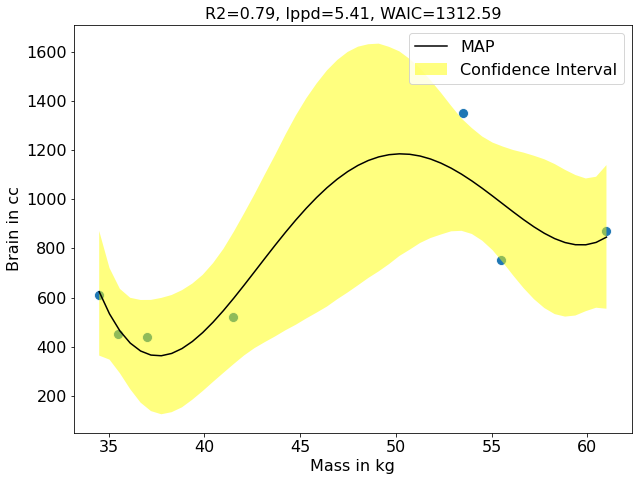

In [37]:
plt.figure(figsize=(10,7.5))

sns.scatterplot(data=dat, x='Mass_kg', y='Brain_cc', s=100)

plt.plot(
    ConfidenceIntervals['Mass_kg'],
    ConfidenceIntervals['MAP'],
    color='k', label='MAP'
)

plt.fill_between(ConfidenceIntervals['Mass_kg'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'], facecolor='yellow', alpha=0.5, label='Confidence Interval')

plt.title('R2='+str(R_2)+', lppd='+str(round(lppd, 2))+', WAIC='+str(round(WAIC, 2)), fontsize=16)
plt.xlabel('Mass in kg', fontsize=16)
plt.ylabel('Brain in cc', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

# Model 5, 5-degree polinomial

In [38]:
with pm.Model() as model_5:
    alpha = pm.Normal('alpha', mu=0.5, sigma=1)
    beta  = pm.Normal('beta', mu=0, sigma=1, shape=5)
    sigma = pm.Lognormal('sigma', mu=0, sigma=1)
    mu    = alpha + beta[0]*mass_std + beta[1]*mass_std**2 + beta[2]*mass_std**3 + beta[3]*mass_std**4 + beta[4]*mass_std**5
    brain = pm.Normal('brain', mu=mu, sigma=sigma, observed=brain_std)

    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta, sigma])

    

In [39]:
param_mu_post = [par_post['alpha'], par_post['beta'][0], par_post['beta'][1], par_post['beta'][2], par_post['beta'][3], par_post['beta'][4], par_post['sigma']]
sample_post   = multivariate_normal.rvs(size=10**4, mean=param_mu_post, cov=np.linalg.inv(hessian))
sample_post   = pd.DataFrame(sample_post, columns=['alpha', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5', 'sigma'])

In [40]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(
        (sample_post['alpha']
        + sample_post['beta1']*mass_seq[0]
        + sample_post['beta2']*mass_seq[0]**2
        + sample_post['beta3']*mass_seq[0]**3
        + sample_post['beta4']*mass_seq[0]**4
        + sample_post['beta5']*mass_seq[0]**5)*brain_max,
        [0.025, 0.975]
    ).reshape(1,2),
    columns=['LCI', 'UCI']
)

In [41]:
for i in range(1, len(mass_seq)):
    ConfidenceIntervals = pd.concat(
        [
            ConfidenceIntervals,
            pd.DataFrame(
                np.quantile(
                    (sample_post['alpha']
                    + sample_post['beta1']*mass_seq[i]
                    + sample_post['beta2']*mass_seq[i]**2
                    + sample_post['beta3']*mass_seq[i]**3
                    + sample_post['beta4']*mass_seq[i]**4
                    + sample_post['beta5']*mass_seq[i]**5)*brain_max,
                    [0.025, 0.975]
                ).reshape(1,2),
                columns=['LCI', 'UCI']
            )
        ]
    )

In [42]:
ConfidenceIntervals['MAP'] = (
    par_post['alpha']
    + par_post['beta'][0]*mass_seq
    + par_post['beta'][1]*mass_seq**2
    + par_post['beta'][2]*mass_seq**3
    + par_post['beta'][3]*mass_seq**4
    + par_post['beta'][4]*mass_seq**5)*brain_max
    
ConfidenceIntervals['Mass_kg'] = mass_seq*dat['Mass_kg'].std()+dat['Mass_kg'].mean()

In [43]:
lppd = 0
penalty = 0
WAIC_sample = []

for i in range(n_dat):
    p_y_post = norm.pdf(
        brain_std[i],
        loc = sample_post['alpha']
            + sample_post['beta1']*mass_std[i]
            + sample_post['beta2']*mass_std[i]**2
            + sample_post['beta3']*mass_std[i]**3
            + sample_post['beta4']*mass_std[i]**4
            + sample_post['beta5']*mass_std[i]**5,
        scale = sample_post['sigma']
    )

    p_y_post         = p_y_post[~np.isnan(p_y_post)]
    log_p_y_post     = np.log(np.mean(p_y_post))
    p_y_post         = p_y_post[p_y_post>0]
    var_log_p_y_post = np.var(np.log(p_y_post)) 
    lppd    += log_p_y_post
    penalty += var_log_p_y_post
    WAIC_sample.append(-2*(log_p_y_post-var_log_p_y_post))

WAIC = -2*(lppd - penalty)
WAIC_std_error = np.sqrt(n_dat*np.var(WAIC_sample))
WAIC_models.append(WAIC)
WAIC_std_error_models.append(WAIC_std_error)

In [44]:
resid = brain_std - (
    par_post['alpha']
    + par_post['beta'][0]*mass_std
    + par_post['beta'][1]*mass_std**2
    + par_post['beta'][2]*mass_std**3
    + par_post['beta'][3]*mass_std**4
    + par_post['beta'][4]*mass_std**5)
R_2   = np.round(1-np.var(resid)/np.var(brain_std), 2)

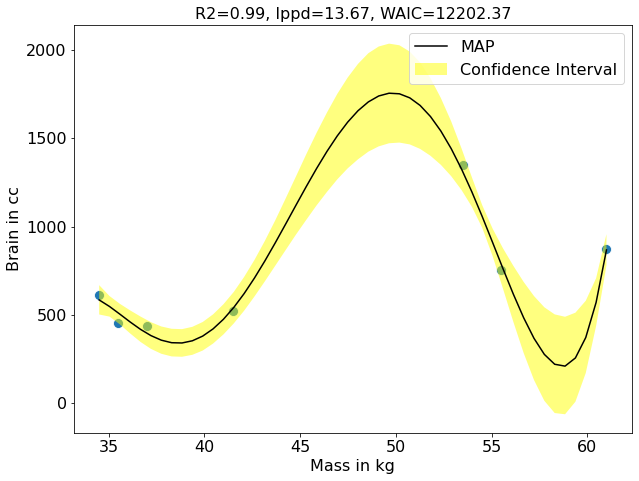

In [45]:
plt.figure(figsize=(10,7.5))

sns.scatterplot(data=dat, x='Mass_kg', y='Brain_cc', s=100)

plt.plot(
    ConfidenceIntervals['Mass_kg'],
    ConfidenceIntervals['MAP'],
    color='k', label='MAP'
)

plt.fill_between(ConfidenceIntervals['Mass_kg'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'], facecolor='yellow', alpha=0.5, label='Confidence Interval')

plt.title('R2='+str(R_2)+', lppd='+str(round(lppd, 2))+', WAIC='+str(round(WAIC, 2)), fontsize=16)
plt.xlabel('Mass in kg', fontsize=16)
plt.ylabel('Brain in cc', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

# Model 6, 6-degree polinomial

In [46]:
with pm.Model() as model_6:
    alpha = pm.Normal('alpha', mu=0.5, sigma=1)
    beta  = pm.Normal('beta', mu=0, sigma=1, shape=6)
    sigma = pm.Lognormal('sigma', mu=0, sigma=1)
    mu    = alpha + beta[0]*mass_std + beta[1]*mass_std**2 + beta[2]*mass_std**3 + beta[3]*mass_std**4 + beta[4]*mass_std**5 + beta[5]*mass_std**6
    brain = pm.Normal('brain', mu=mu, sigma=sigma, observed=brain_std)

    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta, sigma])

    

In [47]:
param_mu_post = [par_post['alpha'], par_post['beta'][0], par_post['beta'][1], par_post['beta'][2], par_post['beta'][3], par_post['beta'][4], par_post['beta'][5], par_post['sigma']]
sample_post   = multivariate_normal.rvs(size=10**4, mean=param_mu_post, cov=np.linalg.inv(hessian))
sample_post   = pd.DataFrame(sample_post, columns=['alpha', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5', 'beta6', 'sigma'])

/home/dmitri/.local/lib/python3.10/site-packages/scipy/stats/_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


In [48]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(
        (sample_post['alpha']
        + sample_post['beta1']*mass_seq[0]
        + sample_post['beta2']*mass_seq[0]**2
        + sample_post['beta3']*mass_seq[0]**3
        + sample_post['beta4']*mass_seq[0]**4
        + sample_post['beta5']*mass_seq[0]**5
        + sample_post['beta6']*mass_seq[0]**6)*brain_max,
        [0.025, 0.975]
    ).reshape(1,2),
    columns=['LCI', 'UCI']
)

In [49]:
for i in range(1, len(mass_seq)):
    ConfidenceIntervals = pd.concat(
        [
            ConfidenceIntervals,
            pd.DataFrame(
                np.quantile(
                    (sample_post['alpha']
                    + sample_post['beta1']*mass_seq[i]
                    + sample_post['beta2']*mass_seq[i]**2
                    + sample_post['beta3']*mass_seq[i]**3
                    + sample_post['beta4']*mass_seq[i]**4
                    + sample_post['beta5']*mass_seq[i]**5
                    + sample_post['beta6']*mass_seq[i]**6)*brain_max,
                    [0.025, 0.975]
                ).reshape(1,2),
                columns=['LCI', 'UCI']
            )
        ]
    )

In [50]:
ConfidenceIntervals['MAP'] = (
    par_post['alpha']
    + par_post['beta'][0]*mass_seq
    + par_post['beta'][1]*mass_seq**2
    + par_post['beta'][2]*mass_seq**3
    + par_post['beta'][3]*mass_seq**4
    + par_post['beta'][4]*mass_seq**5
    + par_post['beta'][5]*mass_seq**6)*brain_max
    
ConfidenceIntervals['Mass_kg'] = mass_seq*dat['Mass_kg'].std()+dat['Mass_kg'].mean()

In [51]:
lppd = 0
penalty = 0
WAIC_sample = []

for i in range(n_dat):
    p_y_post = norm.pdf(
        brain_std[i],
        loc = sample_post['alpha']
            + sample_post['beta1']*mass_std[i]
            + sample_post['beta2']*mass_std[i]**2
            + sample_post['beta3']*mass_std[i]**3
            + sample_post['beta4']*mass_std[i]**4
            + sample_post['beta5']*mass_std[i]**5
            + sample_post['beta6']*mass_std[i]**6,
        scale = sample_post['sigma'][i]
    )

    p_y_post         = p_y_post[~np.isnan(p_y_post)]
    log_p_y_post     = np.log(np.mean(p_y_post))
    p_y_post         = p_y_post[p_y_post>0]
    var_log_p_y_post = np.var(np.log(p_y_post)) 
    lppd    += log_p_y_post
    penalty += var_log_p_y_post
    WAIC_sample.append(-2*(log_p_y_post-var_log_p_y_post))

WAIC = -2*(lppd - penalty)
WAIC_std_error = np.sqrt(n_dat*np.var(WAIC_sample))
WAIC_models.append(WAIC)
WAIC_std_error_models.append(WAIC_std_error)

In [52]:
resid = brain_std - (
    par_post['alpha']
    + par_post['beta'][0]*mass_std
    + par_post['beta'][1]*mass_std**2
    + par_post['beta'][2]*mass_std**3
    + par_post['beta'][3]*mass_std**4
    + par_post['beta'][4]*mass_std**5
    + par_post['beta'][5]*mass_std**6)
R_2   = np.round(1-np.var(resid)/np.var(brain_std), 2)

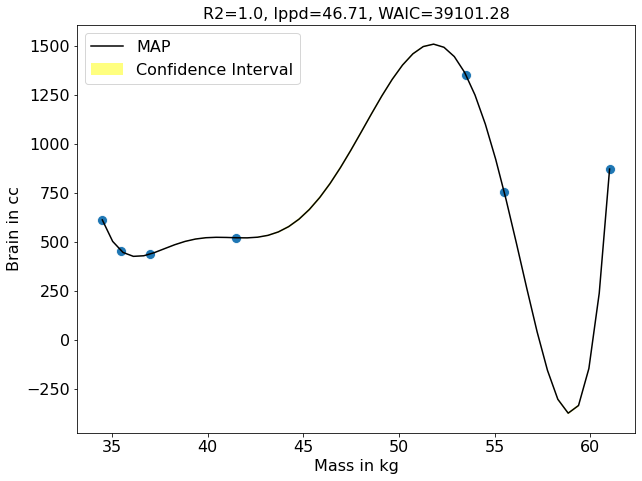

In [53]:
plt.figure(figsize=(10,7.5))

sns.scatterplot(data=dat, x='Mass_kg', y='Brain_cc', s=100)

plt.plot(
    ConfidenceIntervals['Mass_kg'],
    ConfidenceIntervals['MAP'],
    color='k', label='MAP'
)

plt.fill_between(ConfidenceIntervals['Mass_kg'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'], facecolor='yellow', alpha=0.5, label='Confidence Interval')

plt.title('R2='+str(R_2)+', lppd='+str(round(lppd, 2))+', WAIC='+str(round(WAIC, 2)), fontsize=16)
plt.xlabel('Mass in kg', fontsize=16)
plt.ylabel('Brain in cc', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

### Comparing the WAIC for the different models

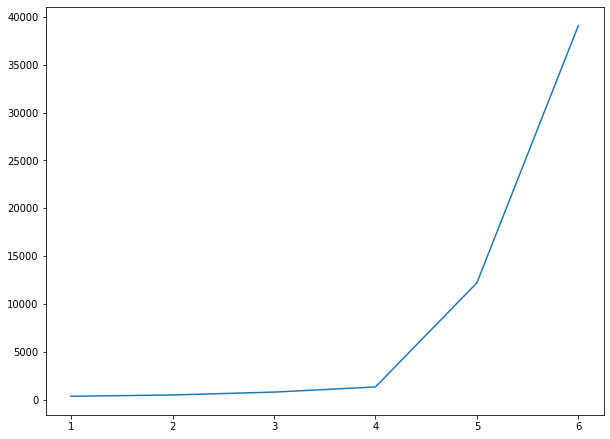

In [54]:
plt.figure(figsize=(10,7.5))
plt.plot(np.arange(1,7), WAIC_models)

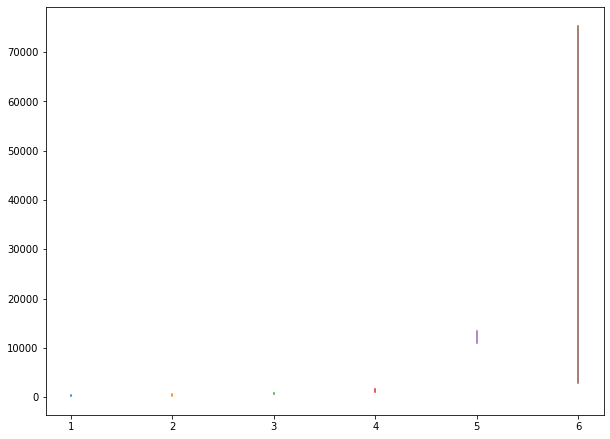

In [55]:
plt.figure(figsize=(10,7.5))
for i in range(6):
    plt.plot([i+1,i+1], [WAIC_models[i]-WAIC_std_error_models[i], WAIC_models[i]+WAIC_std_error_models[i]])

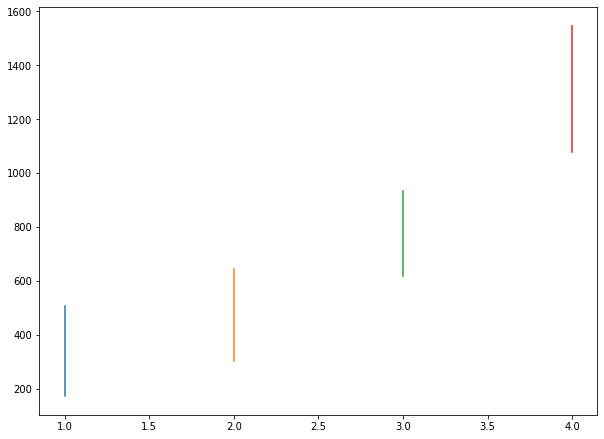

In [56]:
plt.figure(figsize=(10,7.5))
for i in range(4):
    plt.plot([i+1,i+1], [WAIC_models[i]-WAIC_std_error_models[i], WAIC_models[i]+WAIC_std_error_models[i]])